# XGBoost Experiment

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


# Constants

In [8]:
NA_DROP_THRESHOLD = 0.5
CORRELATION_FILTER_THRESHOLD=0.8
KFOLD_N_SPLITS = 3
RANDOM_STATE=42

# Load Dataset

In [4]:
# Load each data table
transactions = pd.read_csv("/kaggle/input/ieee-fraud-detection/train_transaction.csv")
identities = pd.read_csv("/kaggle/input/ieee-fraud-detection/train_identity.csv")

# Merge data tables
df = pd.merge(transactions, identities, on="TransactionID", how="left")

# Free up memory
del transactions
del identities

In [5]:
from sklearn.model_selection import train_test_split

# Take small sample from the whole dataset for testing my code quickly
X_sample = df[:10000].copy()

y_sample = X_sample["isFraud"]
X_sample.drop(columns=["isFraud"], inplace=True)

In [6]:
# Separate features and target values
y = df["isFraud"]
X = df.drop(columns=["isFraud"])

# Dagshub Setup

In [ ]:
!pip install mlflow dagshub

In [10]:
import dagshub
dagshub.auth.add_app_token('ed22b8f88bed7c968c7425f62448b33703f4e094')
dagshub.init(repo_owner='vvaza22', repo_name='ml-assignment-2', mlflow=True)

Accessing as vvaza22

Initialized MLflow to track repo "vvaza22/ml-assignment-2"

Repository vvaza22/ml-assignment-2 initialized!

In [11]:
import mlflow

def log_model(run_name, params, metrics, best_pipeline, figures=[]):
    mlflow.set_experiment("XGBoost_Training")
    mlflow.set_tracking_uri("https://dagshub.com/vvaza22/ml-assignment-2.mlflow")
    
    with mlflow.start_run(run_name=run_name):
        mlflow.log_params(params)
        mlflow.log_metrics(metrics)
        mlflow.sklearn.log_model(best_pipeline, "XGBoost")
        for artifact in figures:
            mlflow.log_artifact(f"/kaggle/working/{artifact}")

# Cleaning

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin

class DropHighNAFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, threshold):
        self._feats_to_drop = []
        self.threshold = threshold
    
    def fit(self, X, y=None):
        
        na_dist = X.isna().mean()
        for feat, na_ratio in na_dist.items():
            if na_ratio > self.threshold:
                self._feats_to_drop.append(feat)
        
        return self

    def transform(self, X):
        X = X.copy()

        # Drop features with high NA content
        X.drop(columns=self._feats_to_drop, inplace=True)

        return X

# Feature Engineering

In [13]:
import category_encoders

# Find every categorical feature in the data
cat_feats = [feat for feat in X.columns if X[feat].dtype == "object"]

# Create woe encoder for the features
woe_encoder = category_encoders.WOEEncoder(cols=cat_feats)

# Final Pipeline

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

def create_pipeline():
    model = xgb.XGBClassifier(eval_metric="auc")
    pipeline = Pipeline([
        ('woe_encoder', woe_encoder),
        ('drop_high_na_feats', DropHighNAFeatures(threshold=NA_DROP_THRESHOLD)),
        ('scaler', StandardScaler()),
        ('classifier', model),
    ])
    return pipeline

# Training

In [94]:
# Specify parameters to try using GridSearch
param_grid = {
    "classifier__max_depth": [3],
    "classifier__n_estimators": [300],
    "classifier__learning_rate": [0.3],
    "classifier__gamma": [0.1, 0.2],
    "classifier__alpha": [0],
    "classifier__scale_pos_weight": [5],
    "classifier__lambda": [1],
}

In [95]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Prepare GridSearch
kfold = StratifiedKFold(n_splits=KFOLD_N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
pipeline = create_pipeline()
grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, scoring='roc_auc', return_train_score=True, verbose=3)

In [96]:
grid_search.fit(X, y)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3] END classifier__alpha=0, classifier__gamma=0.1, classifier__lambda=1, classifier__learning_rate=0.3, classifier__max_depth=3, classifier__n_estimators=300, classifier__scale_pos_weight=5;, score=(train=0.942, test=0.931) total time= 1.0min
[CV 2/3] END classifier__alpha=0, classifier__gamma=0.1, classifier__lambda=1, classifier__learning_rate=0.3, classifier__max_depth=3, classifier__n_estimators=300, classifier__scale_pos_weight=5;, score=(train=0.946, test=0.929) total time=  57.0s
[CV 3/3] END classifier__alpha=0, classifier__gamma=0.1, classifier__lambda=1, classifier__learning_rate=0.3, classifier__max_depth=3, classifier__n_estimators=300, classifier__scale_pos_weight=5;, score=(train=0.945, test=0.929) total time=  56.7s
[CV 1/3] END classifier__alpha=0, classifier__gamma=0.2, classifier__lambda=1, classifier__learning_rate=0.3, classifier__max_depth=3, classifier__n_estimators=300, classifier__scale_pos_weight=

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('woe_encoder',
                                        WOEEncoder(cols=['ProductCD', 'card4',
                                                         'card6',
                                                         'P_emaildomain',
                                                         'R_emaildomain', 'M1',
                                                         'M2', 'M3', 'M4', 'M5',
                                                         'M6', 'M7', 'M8', 'M9',
                                                         'id_12', 'id_15',
                                                         'id_16', 'id_23',
                                                         'id_27', 'id_28',
                                                         'id_29', 'id_30',
                                                         'id_31', 'id_33',
                                                         'id_34', 'id_35',
                                                         'id_36', 'id_37',
                                                         'i...
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             param_grid={'classifier__alpha': [0],
                         'classifier__gamma': [0.1, 0.2],
                         'classifier__lambda': [1],
                         'classifier__learning_rate': [0.3],
                         'classifier__max_depth': [3],
                         'classifier__n_estimators': [300],
                         'classifier__scale_pos_weight': [5]},
             return_train_score=True, scoring='roc_auc', verbose=3)

In [97]:
grid_search.best_score_

0.9295058097210692

In [98]:
grid_search.best_params_

{'classifier__alpha': 0,
 'classifier__gamma': 0.1,
 'classifier__lambda': 1,
 'classifier__learning_rate': 0.3,
 'classifier__max_depth': 3,
 'classifier__n_estimators': 300,
 'classifier__scale_pos_weight': 5}

In [99]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc(model, X, y):
    
    # Predict probabilities
    y_prob = model.predict_proba(X)[:, 1]
    fpr, tpr, thresholds = roc_curve(y, y_prob)
    auc_score = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 8))
    
    plt.title("ROC Curve on Training Set")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.plot(fpr, tpr, color="blue")
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

    plt.tight_layout()
    plt.savefig(f"xgboost_roc_curve.png")
    plt.show()

    # Draw Mirrored ROC curve
    tnr = 1 - fpr
    plt.figure(figsize=(10, 8))
    
    plt.title("Mirrored ROC Curve on Training Set")
    plt.xlabel('True Negative Rate')
    plt.ylabel('True Positive Rate')
    
    plt.plot(tnr, tpr, color="red")
    plt.plot([0, 1], [1, 0], color='gray', linestyle='--')

    plt.tight_layout()
    plt.savefig(f"xgboost_roc_curve_mirrored.png")
    plt.show()

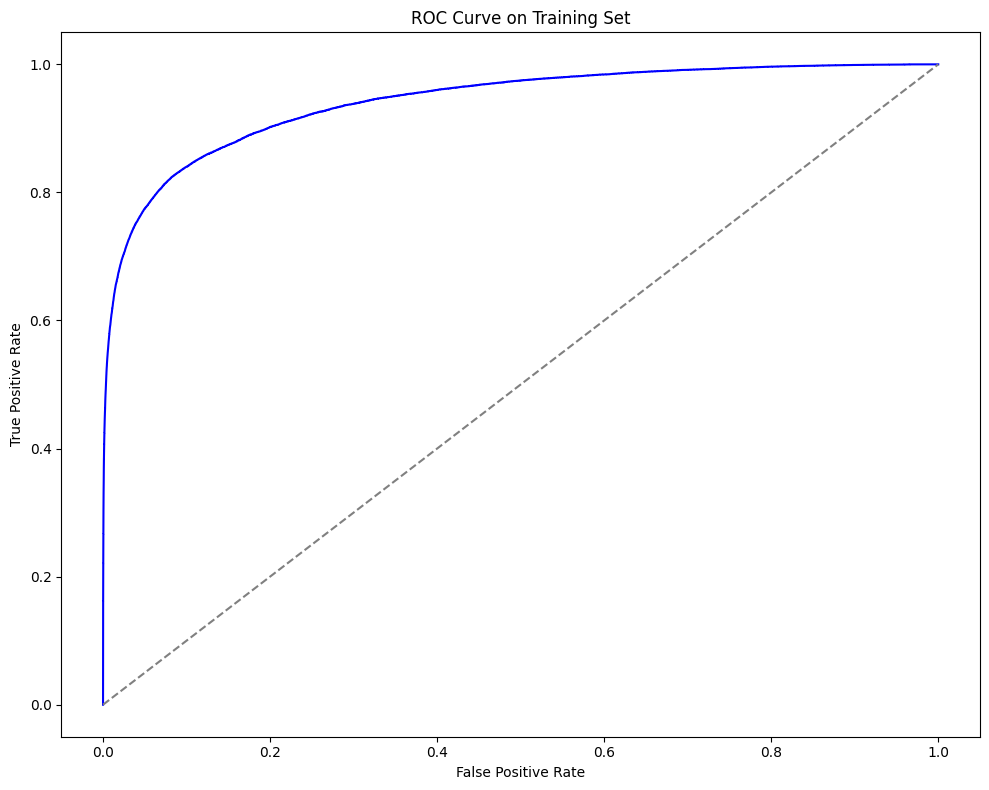

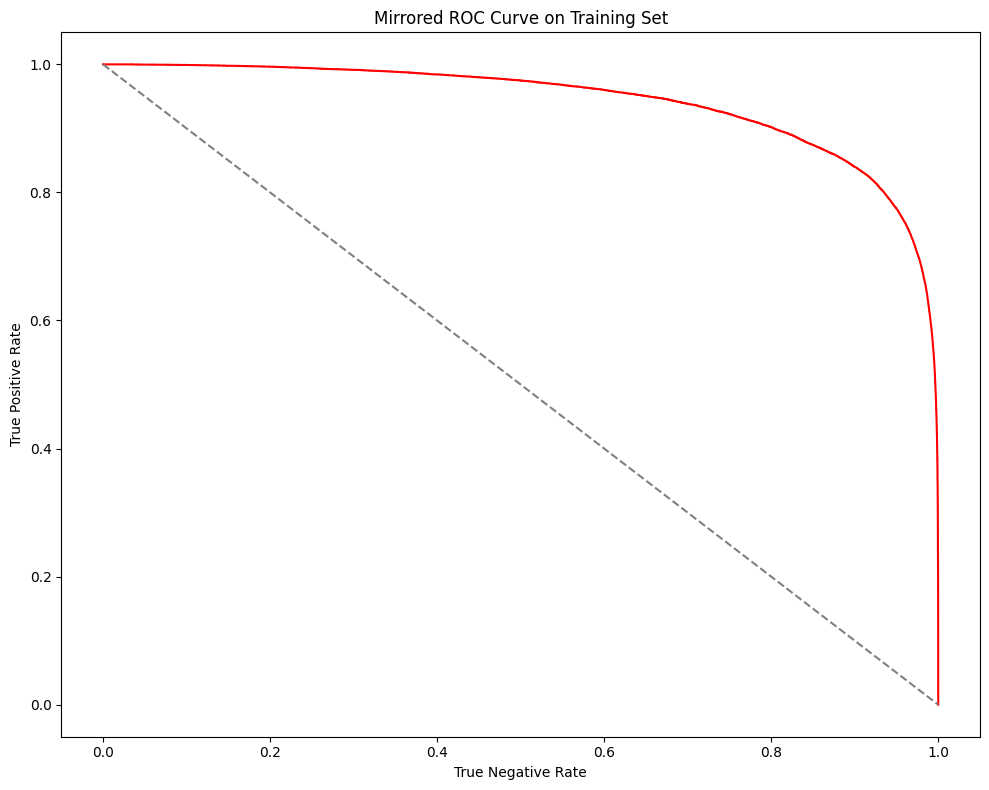

In [100]:
best_pipeline = grid_search.best_estimator_
plot_roc(best_pipeline, X, y)

In [101]:
# https://mlflow.org/docs/latest/traditional-ml/creating-custom-pyfunc/notebooks/override-predict/

class ProbabilityModel(mlflow.pyfunc.PythonModel):
    def __init__(self, model):
        self.model = model

    def load_context(self, context):
        pass

    def predict(self, context, model_input, params=None):
        return self.model.predict_proba(model_input)[:, 1]

/usr/local/lib/python3.11/dist-packages/mlflow/pyfunc/utils/data_validation.py:186: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(


In [102]:
def log_custom_pymodel(run_name, params, metrics, best_pipeline, figures=[]):
    mlflow.set_experiment("XGBoost_Training")
    mlflow.set_tracking_uri("https://dagshub.com/vvaza22/ml-assignment-2.mlflow")
    
    with mlflow.start_run(run_name=run_name):
        mlflow.log_params(params)
        mlflow.log_metrics(metrics)
        mlflow.pyfunc.log_model("XGBoost", python_model=ProbabilityModel(best_pipeline))
        for artifact in figures:
            mlflow.log_artifact(f"/kaggle/working/{artifact}")

In [103]:
params = {
    "random_state": RANDOM_STATE,
    "na_drop_threshold": NA_DROP_THRESHOLD,
    "kfold_n_splits": KFOLD_N_SPLITS,
    **grid_search.best_params_
}

In [104]:
params

{'random_state': 42,
 'na_drop_threshold': 0.5,
 'kfold_n_splits': 3,
 'classifier__alpha': 0,
 'classifier__gamma': 0.1,
 'classifier__lambda': 1,
 'classifier__learning_rate': 0.3,
 'classifier__max_depth': 3,
 'classifier__n_estimators': 300,
 'classifier__scale_pos_weight': 5}

In [105]:
def get_metrics(grid_search):
    results = pd.DataFrame(grid_search.cv_results_)
    
    # Get the best result from the grid search
    best_result = results.sort_values(by="rank_test_score").iloc[0].to_dict()

    # Remove parameter values
    keys_to_drop = []
    for key in best_result.keys():
        if key.startswith("param"):
            keys_to_drop.append(key)
    
    for key in keys_to_drop:
        del best_result[key]

    del best_result["rank_test_score"]

    return best_result

In [106]:
metrics = get_metrics(grid_search)

In [107]:
metrics

{'mean_fit_time': 54.131476958592735,
 'std_fit_time': 1.9732011443455497,
 'mean_score_time': 4.117288986841838,
 'std_score_time': 0.013660381471064407,
 'split0_test_score': 0.930722588487048,
 'split1_test_score': 0.9292035955200528,
 'split2_test_score': 0.9285912451561071,
 'mean_test_score': 0.9295058097210692,
 'std_test_score': 0.0008959747638033075,
 'split0_train_score': 0.9422369536251728,
 'split1_train_score': 0.9461776721730066,
 'split2_train_score': 0.9450806426960254,
 'mean_train_score': 0.9444984228314016,
 'std_train_score': 0.0016606325394022499}

In [108]:
best_pipeline = grid_search.best_estimator_

In [109]:
log_model(
    run_name="XGBoost_Model_2",
    params=params,
    metrics=metrics,
    best_pipeline=best_pipeline,
    figures=["xgboost_roc_curve.png", "xgboost_roc_curve_mirrored.png"]
)

2025/04/27 15:18:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_Model_2 at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/2/runs/a61d23ac60d2470f983802b43c64cf6a
🧪 View experiment at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/2


In [110]:
log_custom_pymodel(
    run_name="XGBoost_Prob_Model_2",
    params=params,
    metrics=metrics,
    best_pipeline=best_pipeline,
    figures=["xgboost_roc_curve.png", "xgboost_roc_curve_mirrored.png"]
)

2025/04/27 15:19:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost_Prob_Model_2 at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/2/runs/59cb03c26eda41509ee97d1a6946b30a
🧪 View experiment at: https://dagshub.com/vvaza22/ml-assignment-2.mlflow/#/experiments/2
